In [4]:
# Import necessary libraries
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

In [5]:
# Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [11]:
train_data_dir = r'C:\Users\Tansam\Documents\PCB Defect Detection\dataset'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 50 files belonging to 10 classes.


In [7]:
class_names = dataset.class_names
class_names

['Burnt',
 'Good_Condition',
 'Missing_Parts',
 'Missing_hole',
 'Mouse_bite',
 'Open_circuit',
 'Short',
 'Spur',
 'Spurious_copper',
 'casing_body_defect']

In [8]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 2 2 7 5 8 0 0 7 8 5 0 0 2 2 3 4 2 2 8 6 3 4 7 3 3 0 4 5 4 4 7]


In [9]:
#Visualize Images From the Dataset

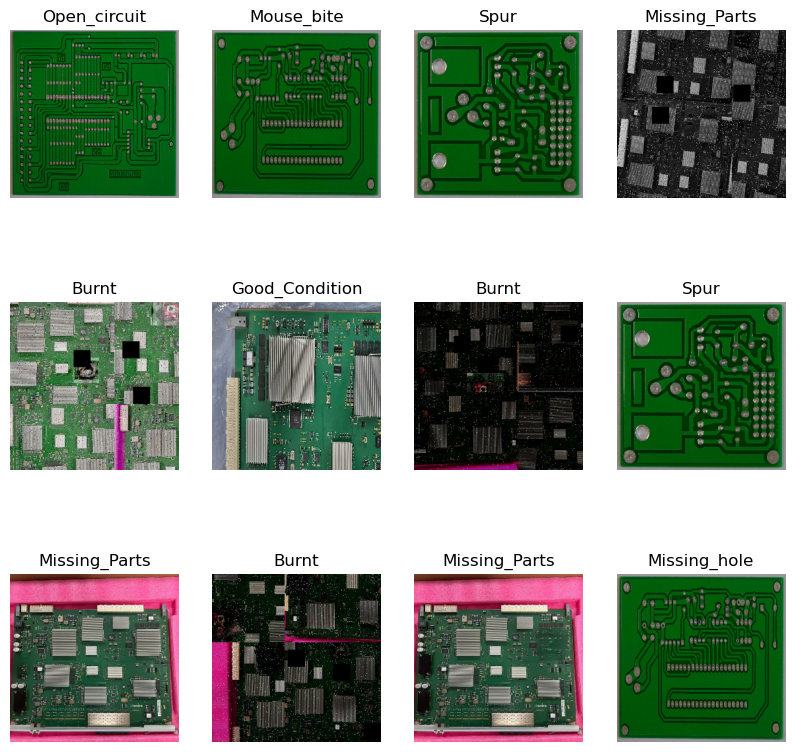

In [10]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [11]:
len(dataset)

28

In [12]:
train_size = 0.8
len(dataset)*train_size

22.400000000000002

In [13]:
train_ds = dataset.take(22)
len(train_ds)

22

In [14]:
test_ds = dataset.skip(22)
len(test_ds)

6

In [15]:
val_size=0.1
len(dataset)*val_size

2.8000000000000003

In [16]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [17]:
test_ds = test_ds.skip(2)
len(test_ds)

4

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [19]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [20]:
len(train_ds)

22

In [21]:
len(val_ds)

2

In [22]:
len(test_ds)

4

In [23]:
#Cache, Shuffle, and Prefetch the Dataset

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
#Building the Model

In [26]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [27]:
#Data Augmentation

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
#Applying Data Augmentation to Train Dataset

In [30]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


In [31]:
#Model Architecture

In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [34]:
unique_labels = set()
for _, labels_batch in dataset:
    unique_labels.update(labels_batch.numpy())

print("Unique Label Values:", unique_labels)


Unique Label Values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


In [35]:
#Compiling the Model

In [36]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

# Your code here
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)


Epoch 1/50


22/22 [==============================] - 17s 565ms/step - loss: 2.1231 - accuracy: 0.1493 - val_loss: 1.7258 - val_accuracy: 0.2656
Epoch 2/50
22/22 [==============================] - 9s 424ms/step - loss: 1.7597 - accuracy: 0.2255 - val_loss: 1.7883 - val_accuracy: 0.2344
Epoch 3/50
22/22 [==============================] - 9s 405ms/step - loss: 1.6730 - accuracy: 0.2401 - val_loss: 1.6281 - val_accuracy: 0.2969
Epoch 4/50
22/22 [==============================] - 9s 404ms/step - loss: 1.6842 - accuracy: 0.1933 - val_loss: 1.6225 - val_accuracy: 0.2500
Epoch 5/50
22/22 [==============================] - 9s 402ms/step - loss: 1.6593 - accuracy: 0.2167 - val_loss: 1.6115 - val_accuracy: 0.2656
Epoch 6/50
22/22 [==============================] - 9s 401ms/step - loss: 1.6453 - accuracy: 0.2269 - val_loss: 1.5718 - val_accuracy: 0.2500
Epoch 7/50
22/22 [==============================] - 9s 403ms/step - loss: 1.6454 - accuracy: 0.2255 - val_loss: 1.6393 - val_accuracy: 0.1875
Epo

In [38]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 3s 94ms/step - loss: 1.5185 - accuracy: 0.3359


In [39]:
# Assuming `model` is your Keras model and `test_ds` is your test dataset
model.summary()  # Check the model summary to verify the output shape

# Print out shapes for debugging
for batch in test_ds:
    features, labels = batch  # Assuming your test dataset yields features and labels
    print("Model Output Shape:", model.predict(features).shape)
    print("Labels Shape:", labels.shape)
    break  # Break after printing the first batch for inspection


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [40]:
scores

[1.518512487411499, 0.3359375]

In [41]:
#Plotting the Accuracy and Loss Curves

In [42]:
history

In [43]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 22}

In [44]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [45]:
type(history.history['loss'])

list

In [46]:
len(history.history['loss'])

50

In [47]:
history.history['loss'][:5] # show loss for first 5 epochs

[2.1230528354644775,
 1.7597044706344604,
 1.6729841232299805,
 1.6842025518417358,
 1.6592888832092285]

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

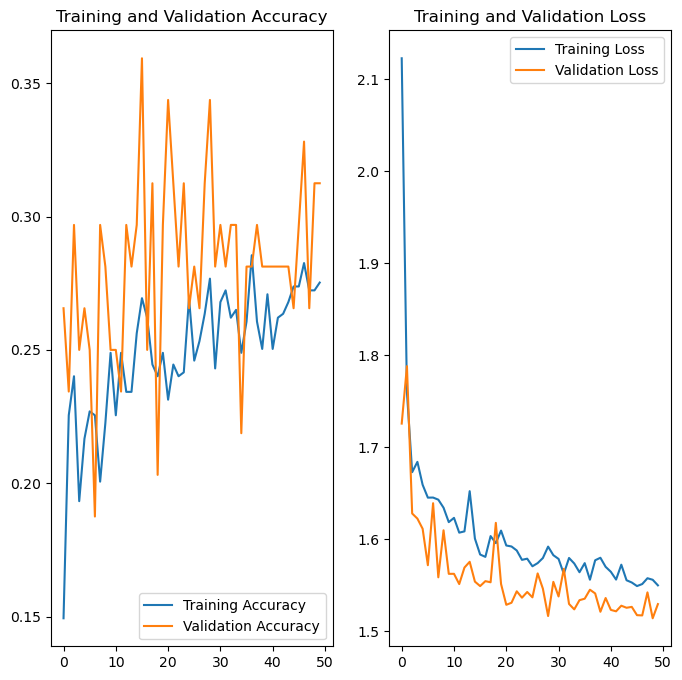

In [49]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [50]:
#Run prediction on a sample image

first image to predict
actual label: Burnt
1/1 [==============================] - 0s 112ms/step
predicted label: Burnt


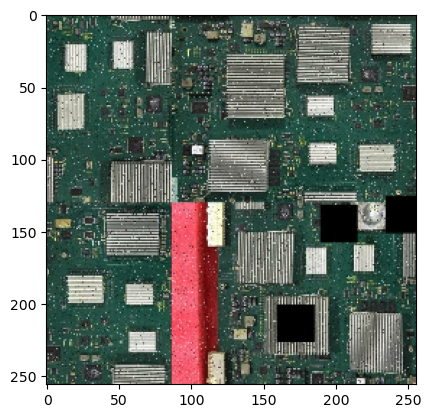

In [51]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [52]:
#Write a function for inference

In [53]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [54]:
#Now run inference on few sample images

1/1 [==============================] - 0s 20ms/step


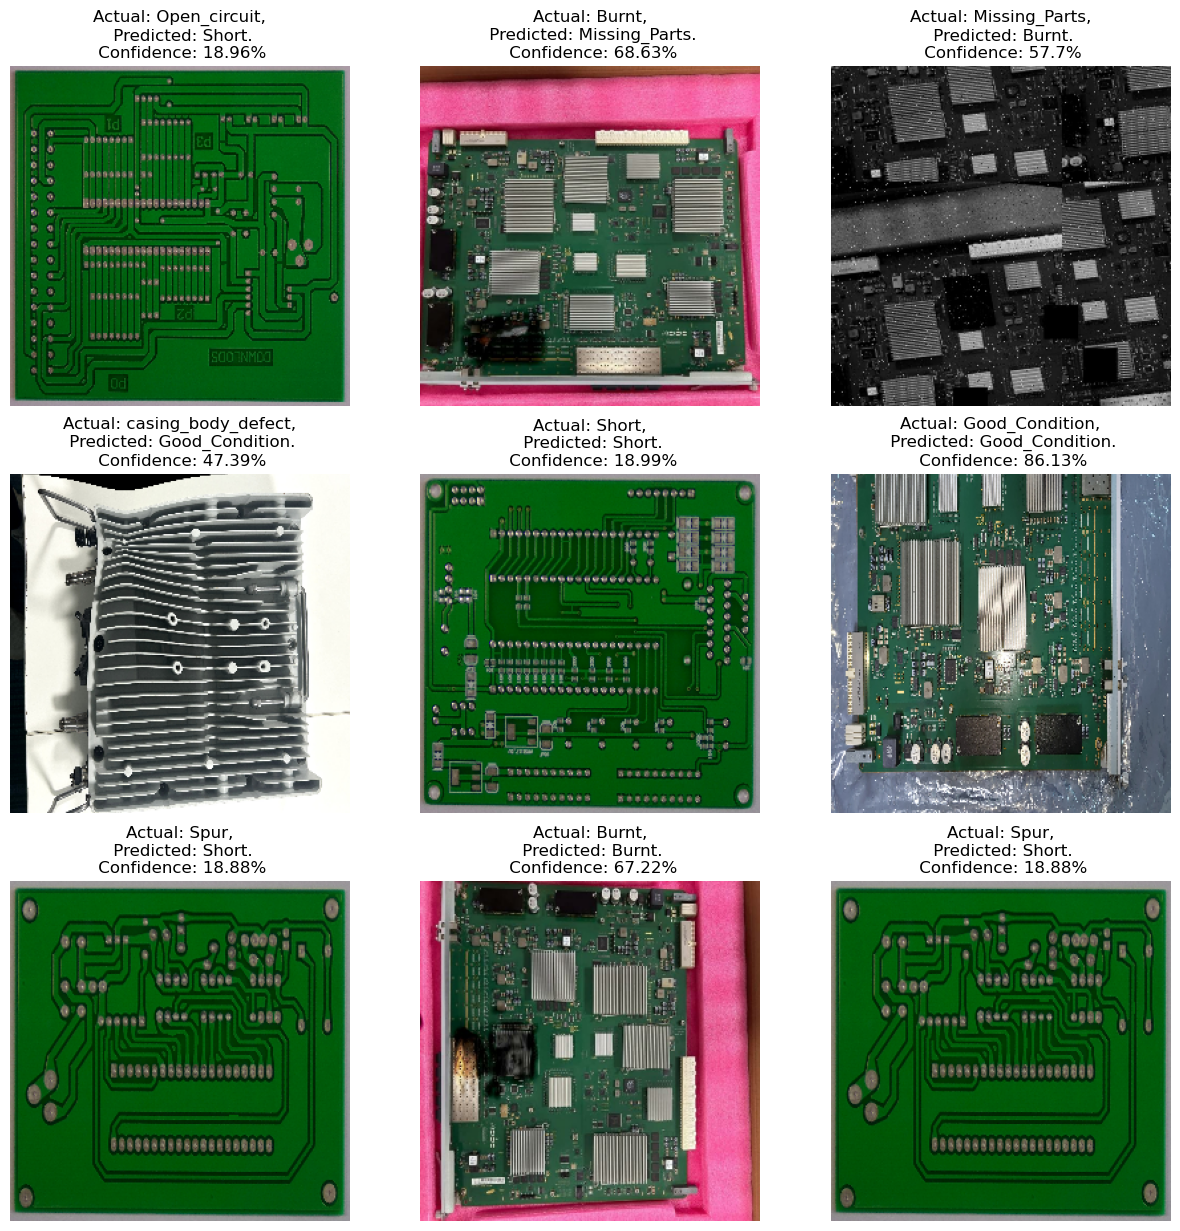

In [55]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [56]:
#Saving the Model

In [ ]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers

# Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
n_classes = 10

# Define the base model
base_model = models.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu')
])

base_model - models.Fit([Flatten]
            mx pooling2D((2, 12))
                        Conv2D(62, 2, 3)
                       )

# Define the two inputs (for the two images)
input_1 = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
input_2 = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Get the embeddings for the two images
embedding_1 = base_model(input_1)
embedding_2 = base_model(input_2)

# Concatenate the two embeddings
concatenated = tf.keras.layers.Concatenate()([embedding_1, embedding_2])

# Add a dense layer
dense1 = layers.Dense(1024, activation='relu')(concatenated)
dense2 = layers.Dense(512, activation='relu')(dense1)
output = layers.Dense(n_classes, activation='softmax')(dense2)

# Define the model
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 64)                   183552    ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 concatenate_1 (Concatenate  (None, 128)                  0         ['sequential_1[0][0]',    

In [10]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

# Define the base model
base_model = models.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(32, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu')
])

# Define the two inputs (for the two images)
input_1 = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
input_2 = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# Get the embeddings for the two images
embedding_1 = base_model(input_1)
embedding_2 = base_model(input_2)

# Concatenate the two embeddings
concatenated = tf.keras.layers.Concatenate()([embedding_1, embedding_2])

# Add a dense layer
dense1 = layers.Dense(1024, activation='relu')(concatenated)
dense2 = layers.Dense(512, activation='relu')(dense1)
output = layers.Dense(n_classes, activation='softmax')(dense2)

# Define the model
model = tf.keras.Model(inputs=[input_1, input_2], outputs=output)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print the model summary
model.summary()

# Load dataset
train_data_dir = r'C:\Users\Tansam\Documents\PCB Defect Detection\dataset'
test_data_dir = r'D:\TANSAM AI Projects\PCB Defect Detection\data\test'

datagen = ImageDataGenerator(validation_split=0.2) # assuming you want to reserve 20% data for validation

train_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')

val_generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')

test_generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Siamese data generator
def siamese_data_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        indices = np.random.choice(batch_x.shape[0], batch_x.shape[0], replace=False)
        batch_x_1 = batch_x
        batch_x_2 = batch_x[indices]
        yield [batch_x_1, batch_x_2], batch_y

train_generator_siamese = siamese_data_generator(train_generator)
val_generator_siamese = siamese_data_generator(val_generator)

# Fit the model
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'}

history = model.fit(
    train_generator_siamese,
    validation_data=val_generator_siamese,
    verbose=1,
    epochs=EPOCHS,
)

# Plot Training and Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), history.history['accuracy'], label='Training Accuracy')
plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), history.history['loss'], label='Training Loss')
plt.plot(range(EPOCHS), history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Test the model
for images_batch, labels_batch in test_generator.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_8 (Sequential)   (None, 64)                   183552    ['input_17[0][0]',            
                                                                     'input_18[0][0]']            
                                                                                                  
 concatenate_8 (Concatenate  (None, 128)                  0         ['sequential_8[0][0]',  

InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\Tansam\anaconda3\Lib\asyncio\base_events.py", line 607, in run_forever
      self._run_once()
    File "C:\Users\Tansam\anaconda3\Lib\asyncio\base_events.py", line 1922, in _run_once
      handle._run()
    File "C:\Users\Tansam\anaconda3\Lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Tansam\AppData\Local\Temp\ipykernel_22340\1098475573.py", line 102, in <module>
      history = model.fit(
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1081, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1139, in compute_loss
      return self.compiled_loss(
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\losses.py", line 2354, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "C:\Users\Tansam\anaconda3\Lib\site-packages\keras\src\backend.py", line 5762, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [32,10] and labels shape [320]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_9530]

In [ ]:
# ... Implement robust error handling for camera issues, model failures, etc.
